#Proyecto de Análisis de imágenes y extracción de información relevante


##Integrantes - Grupo 4


* Sebastian Barcelona - sbarcelona@gmail.com 
* Juan Antonaccio - jmantonaccio@gmail.com 
* Mauricio Ronqui - mronqui@gmail.com 

Link a repo en GoogleDrive: https://drive.google.com/drive/folders/1kWKKKxqxaj385FMCEvq5C7uDgamiWkI2


##Problema 

Actualmente las empresa de transporte de carga terrestre en Uruguay manejan diariamente en su operativa diaria un gran volumen de documentación de diferentes tipos, formatos y con diferente calidad. 
Se dedica una gran cantidad de tiempo en la áres de adiministración y logistica digitando manualmente la información en la visualizada en imagen y pasando la misma al ERP de la empresa. 

Nuestro el proyecto buscar resolver ese problema en una empresa de transporte de carga de Uruguay que tiene actualmente 20 vehiculos y que diariamente recibe y procesa manualmente unos 60 remitos/documentos, de los cuales 30% corresponden a un cliente particular, que tiene un formato y caracteristicas que queremos reconocer, catalogar y digitalizar de forma automatica.

Confidencialidad: la información brindada por la empresa (imagenes y datos) solo podria ser usada para con el fin de presentar el proyecto academico a 4Geeks y UTEC, no pudiendo ser publicada, ni usada con otros fines sin previa autorización de la empresa.

##Objetivo

El proyecto consiste en analizar, normalizar y clasificar imágenes, para luego detectar y extraer información por medio de uso de OCR.

##Alcance: 

Dado un dataset de imágenes de remitos con un tipo y formato conocido que llamaremos Remito_Ok y un segundo dataset de Remitos de multiples clientes, tipos y formatos que llamaremos Remitos_Varios, realizaremos un analisis EDA, luego una normalización y por ultimo entrenaremos un modelo, de diferentes formas hasta conseguir el mejor resultado posible, por ultimo nos quedaremos con un modelo el de mejor comportamiento y procederemos a usarlo para detectar imangenes y extraer información por medio del uso de OCR.

#Fase 1 - EDA

Dado que las imagenes del dataset Remito_OK tienen diferentes valores y atributos: tamaño, brillo y calidad, vamos a genera un EDA que nos permita evaluar los requisitos minimos para entender factores que afectan el entrenamiento del modelo y la correcta lectura al aplicar OCR, logrando a travez del analisis de los datos, determinar minimos aceptables de tamaño, brillo y calidad, para aplicar filtros en la fase 2.

#Fase 2 - Normalización y Filtros

Con la información obtenida en la fase 1, crearemos otro dataset de Remito_Ok y Remitos Varios base en esos parametros, realizando procedimientos que aseguren que las imagenes que pasen, cumplen con esas condiciones. Creando un segundo dataset con datos normalizados para entrenar el modelo.

#Fase 3 - Clasificación

Con los dos dataset obtenidos en la fase 1 y 2, así como los valores de ajustes obtenidos del analisis EDA, entrenaremos el modelo y evaluaremos los resultados obtenidos. El modelo debe ser capaz de detectar si una imagen nueva es un Remito_OK o no lo es, por medio de la clasificación de imagenes usando redes neuronales.

#Fase 4 - Clasificación, Data Augmentation y Tranfer Learning

En esta fase usaremos Data Augmentation y Tranfer Learning, con el fin de agrandar la muestra y entrenaremos el modelo aprovechando el conocimiento del otro modelo y evaluaremos los resultados obtenidos

#Fase 5 - API y OCR  
Para los caso que la fase 3 o 4 determine que es un Remito_OK, se procesará con funciones para extraerle la información mediante uso de OCR y devolver la misma mediante una API, si cumplen serán evaludadas por el modelo y sino rechazarlas.

##METODOLOGIA para entrenamiento de MODELOS

Usamos dos fuentes de datos para entrenar el modelo y poder sacar conclusiones de como afectaban la forma en que el modelo predice. 

Dataset 1 - Se entrena con datos inciales sin procesar (raw)     
https://drive.google.com/drive/folders/1qBq--Fi33n0NcK0HJMj4AOk9CvpXVOhl

Dataset 2 - Se entrena con un datos procesados en procesados según valores de obtenidos en analisis EDA https://drive.google.com/drive/folders/1rZBgiONiKhy6Mrk4CBPAJfA3Ck9YiVM6



##PASO A PASO - FASES del PROYECTO
Instalaciones de librerias y imports

In [ ]:
# Instalar librerias
%%capture

#!pip install --upgrade pip
!pip install pandas numpy matplotlib scikit-learn
!sudo apt-get install tesseract-ocr
!pip install pytesseract==0.3.9
!pip install opencv-python
!pip install Pillow
!pip install imutils
!pip install tensorflow
!pip install opencv-python-headless 


In [ ]:
# Incluir librerias
# System --------------------------------------------------------
import os
import pathlib
# Dataframes and matrices ---------------------------------------
import numpy as np
import pandas as pd
# Graphics ------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Machine learning ----------------------------------------------
from sklearn.model_selection import train_test_split
# Deep learning -------------------------------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout, Flatten
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import datasets, layers, models
#from keras.utils import load_img
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.utils.data_utils import get_file
from keras.preprocessing.image import image_dataset_from_directory
# GoogleDrive --------
from google.colab import drive
from google.colab.patches import cv2_imshow

# Manejo de carpetas
import os.path
from os import path

# Foco de imagene
import argparse

# Medir tiempo de codigo
from tqdm import tqdm

##FASE 1 - EDA
Montar dataset desde GoogleDrive
Realizar EDA 

In [ ]:
# Conectamos a GoogleDrive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Variables globals
BASE_PATH = "/content/drive/My Drive/AI - Proyecto Final/DataSet/images_raw/"
#BASE_PATH_DS_MODEL="/content/drive/Compartido conmigo/AI - Proyecto Final/DataSet/imagenesModel/"
BASE_PATH_DS_MODEL_REZIDE="/content/drive/MyDrive/AI - Proyecto Final/DataSet/imagenesResized/"

OK_IMG_PATH = os.path.join(BASE_PATH, "Remito_OK") 
VARIOS_IMG_PATH = os.path.join(BASE_PATH, "Remitos_Varios")

Tamaño del dataset sin procesar

In [ ]:
print('Number of Remitos OK: ', len([name for name in os.listdir(OK_IMG_PATH)]))
print('Number of Remitos Varios: ', len([name for name in os.listdir(VARIOS_IMG_PATH)]))

Number of Remitos OK:  195
Number of Remitos Varios:  982


In [ ]:
def print_folder_statistics(path):
    d_image_sizes = {}
    for image_name in tqdm(os.listdir(path)):
        image = cv2.imread(os.path.join(path, image_name))
        d_image_sizes[image.shape] = d_image_sizes.get(image.shape, 0) + 1
        
    for size, count in d_image_sizes.items():
        print(f"shape: {size}\tcount: {count}")

Agrupamos imagenes por clase y por valores similares

In [ ]:
print(f"Remito OK:")
print_folder_statistics(OK_IMG_PATH)
print("-" * 10)
print(f"Remitos Varios:")
print_folder_statistics(VARIOS_IMG_PATH)
print("-" * 10)

Remito OK:


100%|██████████| 195/195 [00:25<00:00,  7.62it/s]


shape: (409, 230, 3)	count: 2
shape: (225, 400, 3)	count: 52
shape: (230, 409, 3)	count: 1
shape: (400, 300, 3)	count: 12
shape: (300, 400, 3)	count: 38
shape: (400, 225, 3)	count: 10
shape: (176, 128, 3)	count: 1
shape: (216, 384, 3)	count: 2
shape: (128, 176, 3)	count: 1
shape: (900, 1600, 3)	count: 1
shape: (3120, 4160, 3)	count: 25
shape: (4160, 3120, 3)	count: 50
----------
Remitos Varios:


100%|██████████| 982/982 [00:18<00:00, 52.89it/s] 

shape: (1600, 900, 3)	count: 3
shape: (900, 1600, 3)	count: 5
shape: (1599, 899, 3)	count: 4
shape: (2048, 1152, 3)	count: 1
shape: (2000, 1500, 3)	count: 1
shape: (432, 324, 3)	count: 4
shape: (400, 225, 3)	count: 384
shape: (225, 400, 3)	count: 98
shape: (4096, 2304, 3)	count: 1
shape: (899, 1599, 3)	count: 1
shape: (1200, 1600, 3)	count: 2
shape: (400, 300, 3)	count: 176
shape: (1600, 1200, 3)	count: 2
shape: (300, 400, 3)	count: 65
shape: (409, 307, 3)	count: 16
shape: (176, 128, 3)	count: 65
shape: (268, 525, 3)	count: 1
shape: (400, 180, 3)	count: 3
shape: (403, 302, 3)	count: 1
shape: (409, 230, 3)	count: 61
shape: (386, 386, 3)	count: 5
shape: (230, 409, 3)	count: 9
shape: (512, 384, 3)	count: 1
shape: (409, 409, 3)	count: 7
shape: (384, 216, 3)	count: 26
shape: (400, 200, 3)	count: 6
shape: (216, 384, 3)	count: 9
shape: (512, 237, 3)	count: 1
shape: (512, 288, 3)	count: 2
shape: (400, 295, 3)	count: 1
shape: (264, 469, 3)	count: 2
shape: (360, 203, 3)	count: 1
shape: (400, 292

Generamos un dataframe para analizar los datos de las imagenes y graficarlos

In [ ]:
data_train = []
for filename in os.listdir(OK_IMG_PATH):
  data_train.append(filename)
#data_train

In [ ]:
df_train_raw = pd.DataFrame(data_train,columns=['imagen'])
df_train_raw

,imagen
0,1660.jpg
1,1681.jpg
2,1968.jpg
3,1996.jpg
4,1997.jpg
...,...
190,IMG_20220817_114351.jpg
191,IMG_20220817_114357.jpg
192,IMG_20220817_114411.jpg
193,11841.jpg


In [ ]:
def leer_imagen(img):
  image=cv2.imread(os.path.join(OK_IMG_PATH,img))
  ancho = image.shape[0]
  alto = image.shape[1]
  return ancho,alto

In [ ]:
r1,r2 = leer_imagen(df_train_raw['imagen'][8])
print(r1,r2,df_train_raw['imagen'][8])

225 400 2598.jpg


In [ ]:
df_train_raw['ancho'],df_train_raw['alto'] = zip(*df_train_raw['imagen'].apply(lambda x:leer_imagen(x)))
df_train_raw

,imagen,ancho,alto
0,1660.jpg,409,230
1,1681.jpg,225,400
2,1968.jpg,230,409
3,1996.jpg,225,400
4,1997.jpg,225,400
...,...,...,...
190,IMG_20220817_114351.jpg,4160,3120
191,IMG_20220817_114357.jpg,4160,3120
192,IMG_20220817_114411.jpg,3120,4160
193,11841.jpg,300,400


Además del Alto y Ancho, evaluamos el aributo de las imagenes que es cuan en foco están.

In [ ]:

def variance_of_laplacian(img):
	# compute the Laplacian of the image and then return the focus
	# measure, which is simply the variance of the Laplacian
	image=cv2.imread(os.path.join(OK_IMG_PATH,img ))
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	return cv2.Laplacian(gray, cv2.CV_64F).var()

In [ ]:
img = df_train_raw['imagen'][0]
fm = variance_of_laplacian(img)
fm

4635.24988054692

In [ ]:
df_train_raw['bluebr']=df_train_raw.apply(lambda x: variance_of_laplacian(x['imagen']),axis=1)

Revisamos min, max y graficamos para conocer más información de las imagenes

In [ ]:
df_train_raw.describe()

,ancho,alto,bluebr
count,195.000000,195.000000,195.000000
mean,1644.020513,1566.107692,626.620639
std,1747.610979,1540.261072,830.202328
min,128.000000,128.000000,6.994568
25%,225.000000,400.000000,45.233202
50%,400.000000,400.000000,423.645234
75%,4160.000000,3120.000000,923.139102
max,4160.000000,4160.000000,4932.585654


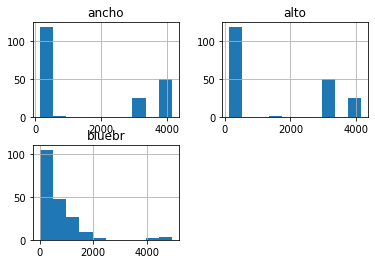

In [ ]:
df_train_raw.hist()
plt.show()

Analizamos la NITIDEZ de las imagenes

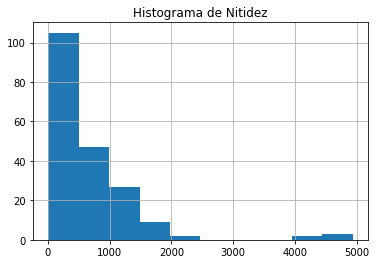

In [ ]:
df_train_raw['bluebr'].hist()
plt.title("Histograma de Nitidez")
plt.show()

Observamos que las imagenes que tienen un valor mayor a 1000 son dificiles de leer, con el ojo humano y por tanto son candidatas a rechazarse, para verificarlo listamos y revisamos algunas imagenes 

In [ ]:
df_train_raw_rechazar =df_train_raw[df_train_raw['bluebr']>1000]
df_train_raw_rechazar.head(5)

,imagen,ancho,alto,bluebr
0,1660.jpg,409,230,4635.249881
2,1968.jpg,230,409,4932.585654
3,1996.jpg,225,400,1937.263156
4,1997.jpg,225,400,1136.216997
9,2597.jpg,225,400,1084.685286


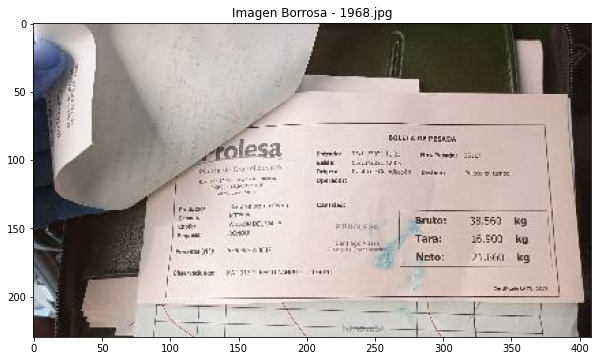

In [ ]:
image=cv2.imread(os.path.join(OK_IMG_PATH,'1968.jpg'))
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.title('Imagen Borrosa - 1968.jpg')
plt.show()

Las imagenes con valores menores a 1000 se puede leer, por lo cual son de buena calidad, para verificarlo listamos y revisamos algunas imagenes 

In [ ]:
df_train_raw_calidad_ok=df_train_raw[df_train_raw['bluebr']<1000]
df_train_raw_calidad_ok.head(5)

,imagen,ancho,alto,bluebr
1,1681.jpg,225,400,821.591951
5,2001.jpg,225,400,181.152703
6,2452.jpg,225,400,978.898376
7,2531.jpg,225,400,543.906179
8,2598.jpg,225,400,990.867937


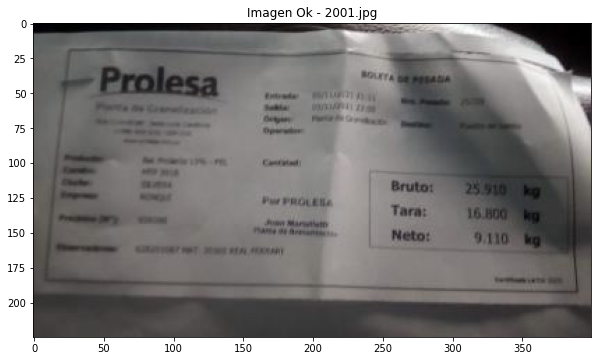

In [ ]:
# Ejemplo de Remito_OK
sample_Remito_Ok = cv2.imread(os.path.join(OK_IMG_PATH, '2001.jpg'))
plt.figure(figsize=(10,10))
plt.imshow(sample_Remito_Ok)
plt.title('Imagen Ok - 2001.jpg')
plt.show()

Comparamos las imagenes filtradas de buena calidad con las imagenes raw, viendo que la perdida de imagenes es de un 21%

In [ ]:
print(df_train_raw_calidad_ok.shape)
print(df_train_raw.shape)

(153, 4)
(195, 4)


Analizamos el ANCHO de las imagenes

In [ ]:
df_train_raw_calidad_rechazadas_ancho =df_train_raw[df_train_raw['ancho']<240]
df_train_raw_calidad_rechazadas_ancho.head(5)

,imagen,ancho,alto,bluebr
1,1681.jpg,225,400,821.591951
2,1968.jpg,230,409,4932.585654
3,1996.jpg,225,400,1937.263156
4,1997.jpg,225,400,1136.216997
5,2001.jpg,225,400,181.152703


El ANCHO de las imagenes por menores a 240 hacer perder mucha información del Dataset un 29%

In [ ]:
print(df_train_raw_calidad_rechazadas_ancho.shape)
print(df_train_raw.shape)

(57, 4)
(195, 4)


Analizamos el ALTO de las imagenes



In [ ]:
df_train_raw_calidad_rechazadas_alto =df_train_raw[df_train_raw['alto']<240]
df_train_raw_calidad_rechazadas_alto.head(5)

,imagen,ancho,alto,bluebr
0,1660.jpg,409,230,4635.249881
45,4502.jpg,400,225,680.511663
49,4910.jpg,400,225,870.995564
73,10935.jpg,400,225,238.422152
76,11065.jpg,176,128,1149.504904


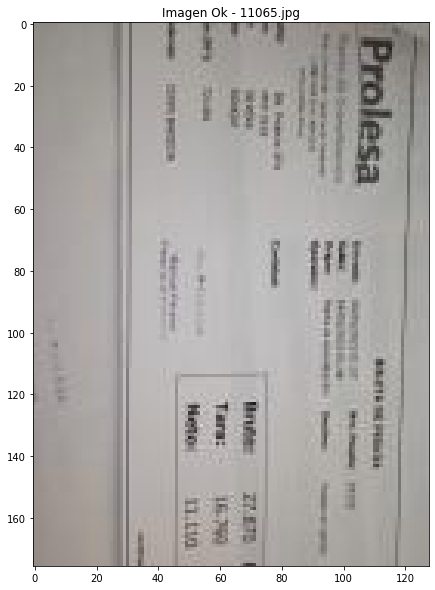

In [ ]:
# Ejemplo de Remito_OK
sample_Remito_Ok = cv2.imread(os.path.join(OK_IMG_PATH, '11065.jpg'))
plt.figure(figsize=(10,10))
plt.imshow(sample_Remito_Ok)
plt.title('Imagen Ok - 11065.jpg')
plt.show()
# Menores a 240 de ancho rechazarla por ancho pero en este caso esta girada.

El ALTO de las imagenes por menores a 240 la perdida de imagenes es 7%

In [ ]:
print(df_train_raw_calidad_rechazadas_alto.shape)
print(df_train_raw.shape)

(14, 4)
(195, 4)


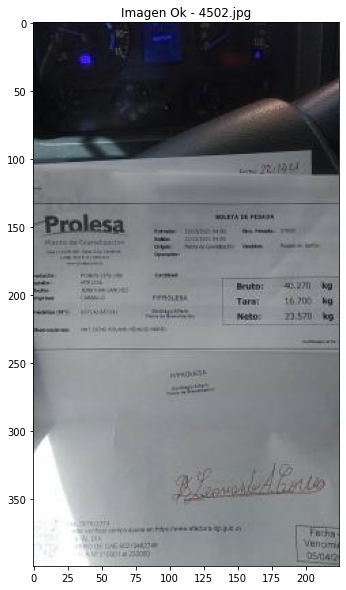

In [ ]:
# Ejemplo de Remito_OK
sample_Remito_Ok = cv2.imread(os.path.join(OK_IMG_PATH, '4502.jpg'))
plt.figure(figsize=(10,10))
plt.imshow(sample_Remito_Ok)
plt.title('Imagen Ok - 4502.jpg')
plt.show()

In [ ]:
df_train_raw_calidad_final =df_train_raw[df_train_raw['alto']>240]
df_train_raw_calidad_final =df_train_raw_calidad_final[df_train_raw_calidad_final['ancho']>240]
df_train_raw_calidad_final =df_train_raw_calidad_final[df_train_raw_calidad_final['bluebr']<1000]

Combinando ALTO, ANCHO y NITIDEZ de las imagenes la perdida de información del Dataset un 31%

In [ ]:
print(df_train_raw_calidad_final.shape)
print(df_train_raw.shape)

(135, 4)
(195, 4)


##FASE 2 - Normalizacion y Filtros
Dado los requisitos minimos analizados en el EDA, vamosa a ajustar las imagenes raw, para crear un nuevo dataser imagenesResized de Remitos_Ok y Remitos_Varios para que puedan ser utilizados para entrenar al modelo.

Solo las que pasen este filtro de normalización, alto, ancho y nitidez, entra al dataser y serán usado en el modelo de clasificación.

In [ ]:
# Verifico si existen y creo carptetas

if os.path.exists(BASE_PATH_DS_MODEL_REZIDE):
   #if not os.path.exists(os.path.join(BASE_PATH_DS_MODEL_REZIDE, 'Remito_OK')):
      os.makedirs(os.path.join(BASE_PATH_DS_MODEL_REZIDE, 'Remito_OK'))
   #if not os.path.exists(os.path.join(BASE_PATH_DS_MODEL_REZIDE, 'Remitos_Varios')):
      os.makedirs(os.path.join(BASE_PATH_DS_MODEL_REZIDE, 'Remitos_Varios'))

In [ ]:
#verifico contenido
os.chdir(BASE_PATH_DS_MODEL_REZIDE)
!ls

Remito_OK  Remitos_Varios


In [ ]:
# Recorre las imagenes Remito OK raw y las convierte en imangenes de tamaños 300 x 300 y verifica que la laplancian sea mayor a 1000
i = 0
images = os.listdir(OK_IMG_PATH)
list_images = [f'/content/drive/MyDrive/AI - Proyecto Final/DataSet/images_raw/Remito_OK/{file_name}' for file_name in images]
for img in list_images:
    image = cv2.imread(img)
    try:
        if variance_of_laplacian(img)<1000:
          img_resized = cv2.resize(image,(240,240))
          cv2.imwrite(os.path.join(BASE_PATH_DS_MODEL_REZIDE, 'Remitos_OK/', 'image%04i.jpg') %i, img_resized)
          i += 1
        else:
          print(f'Error in calidad - image {img}')
    except:
        print(f'Error in image {img}')
print(f'Processed images:{i}')

In [ ]:
# Recorre las imagenes Remitos_Varios raw y las convierte en imangenes de tamaños 300 x 300 y verifica que la laplancian sea mayor a 1000
i = 0
images = os.listdir(VARIOS_IMG_PATH)
list_images = [f'/content/drive/MyDrive/AI - Proyecto Final/DataSet/images_raw/Remitos_Varios/{file_name}' for file_name in images]
for img in list_images:
    image = cv2.imread(img)
    try:
        if variance_of_laplacian(img)<1000:
          img_resized = cv2.resize(image,(240,240))
          cv2.imwrite(os.path.join(BASE_PATH_DS_MODEL_REZIDE, 'Remitos_Varios/', 'image%04i.jpg') %i, img_resized)
          i += 1
        else:
          print(f'Error in calidad - image {img}')  
    except:
        print(f'Error in image {img}')
print(f'Processed images:{i}')

In [ ]:
# No lo vamos a pasarla a blanco y negro
# 56700 (240*240) + 3 canales = 172800 matriz para mantener mayor información que con un solo canal (el color nos agrega contexto)

##FASE 3 - Clasificación 
Modelo de redes neuronales para determianr si es o no un Remito_OK

Usaremos dos dataset: 
- images_raw (set de datos iniciales sin procesar)
- imagenesResized (imagenes normalizadas y filtradas en FASE 2)

Generamos las clases training

In [ ]:
IMAGE_WITDH = 240
IMAGE_HEIGHT = 240
BATCH_SIZE = 32
VAL_SPLIT = 0.2
#Imagenes separadas desde raw filtradas
#IMG_DIR_TRAIN= '/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesResized/'
#Imanges originales
IMG_DIR_TRAIN= '/content/drive/My Drive/AI - Proyecto Final/DataSet/images_raw/'


train_ds = tf.keras.utils.image_dataset_from_directory(
  IMG_DIR_TRAIN,   
  validation_split=VAL_SPLIT, #tamaño de la muestra
  subset="training",
  seed=123,
  image_size=(IMAGE_HEIGHT, IMAGE_WITDH), #tamaño
  batch_size=BATCH_SIZE) #lote

Found 1177 files belonging to 2 classes.
Using 942 files for training.


Generamos las clases validation

In [ ]:
# Create validation dataset, con un 20% de las imagenes de Remitos OK y Remitos Varios

#IMG_DIR_VAL= '/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesResized/'
IMG_DIR_VAL= '/content/drive/My Drive/AI - Proyecto Final/DataSet/images_raw/'

val_ds = tf.keras.utils.image_dataset_from_directory(
  IMG_DIR_VAL, 
  validation_split=VAL_SPLIT,
  subset="validation",
  seed=123,
  image_size=(IMAGE_HEIGHT, IMAGE_WITDH),
  batch_size=BATCH_SIZE)
  #El archivo de validacion va a hacer el tunning de la red neuronal

Found 1177 files belonging to 2 classes.
Using 235 files for validation.


Creamos la arquitectura de deep learning

In [ ]:
# Create the deep learning architecture

IMAGE_CHANNELS=3 #las imanges a color tienen 3 canales RGB
IMAGE_WIDTH=240
IMAGE_HEIGHT=240

model = Sequential([

#capa de convolucion primer argumento Kernel Size 32 // el segundo (3,3) stride es una tupla de a cuanto bloques ir saltando
# stride debe ser impares (5,5) o  (7,7) 
# relu es la funcion de activacion hay otras como (sigmoid o tanh)
Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)), #convolucion 
BatchNormalization(), #normalizacion trata de llevalo a un rango de valores para que datos muy chicos o muy grande no interfieran
MaxPooling2D(pool_size=(2, 2)), #tomo el maximo
Dropout(0.25), # tecnica para que la red neuronal no se aprenda de memoria la estructura de los datos anulo neuronas

#capa de convolucion
Conv2D(64, (3, 3), activation='relu'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

#capa de convolucion
Conv2D(128, (3, 3), activation='relu'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Flatten(), # toma la mtriz cuadrada y la estira como si fuera una linea o una columna como si fuera regresion lineal
Dense(512, activation='relu'),
BatchNormalization(),
Dropout(0.5),
Dense(1, activation='sigmoid'), # 
])

#compila el modelo y en la funcion de perdida uso binary_crossentropy po
# optimizer adam (hay otros)
# metricas accuracy (proporcion de prediciones correctas sobre el total )
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 238, 238, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 119, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 119, 119, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 117, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 117, 117, 64)     2

Verificamos las clases creadas

In [ ]:
train_ds.class_names

['Remito_OK', 'Remitos_Varios']

Entrenamos el Modelo 

In [ ]:
history=model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
30/30 [==============================] - 621s 16s/step - loss: 0.8842 - accuracy: 0.7633 - val_loss: 0.4994 - val_accuracy: 0.8383
Epoch 2/10
30/30 [==============================] - 8s 211ms/step - loss: 0.4355 - accuracy: 0.8577 - val_loss: 0.9193 - val_accuracy: 0.5106
Epoch 3/10
30/30 [==============================] - 8s 212ms/step - loss: 0.3953 - accuracy: 0.8439 - val_loss: 0.7350 - val_accuracy: 0.8723
Epoch 4/10
30/30 [==============================] - 8s 211ms/step - loss: 0.2246 - accuracy: 0.9268 - val_loss: 0.3898 - val_accuracy: 0.8936
Epoch 5/10
30/30 [==============================] - 8s 212ms/step - loss: 0.1579 - accuracy: 0.9469 - val_loss: 0.3076 - val_accuracy: 0.9021
Epoch 6/10
30/30 [==============================] - 8s 214ms/step - loss: 0.1182 - accuracy: 0.9586 - val_loss: 0.5146 - val_accuracy: 0.9064
Epoch 7/10
30/30 [==============================] - 8s 216ms/step - loss: 0.0832 - accuracy: 0.9777 - val_loss: 0.3102 - val_accuracy: 0.9064
Epoch 

In [ ]:
history.history

Evaluamos como predijo el modelo 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


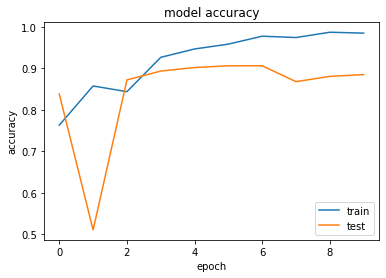

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# hay overfit el acuracy en train es  0.9893842935562134 y en test 0,91 hay mucha diferencia por tanto hay overfitting 

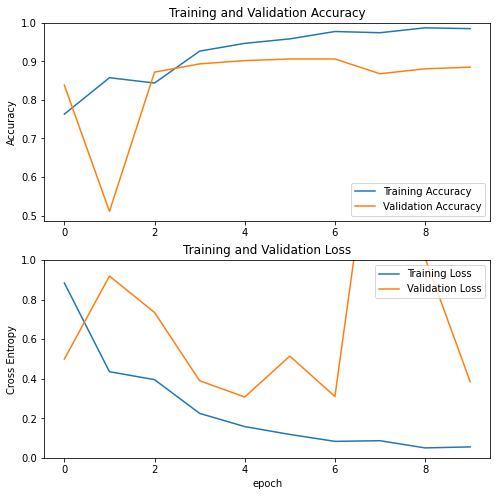

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Salvamos el modelo

In [ ]:
model.save('remito_model.h5')

Creamos una funcion que permita darle el formato a la imagen esperado por el modelo.

In [ ]:
def load_img(filename):
    IMAGE_WIDTH=240
    IMAGE_HEIGHT=240 
    img = cv2.imread(filename)
    try:
        img_resized = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT))
    except:
        print(f'Error in image {img}')
    return img_resized

Leemos el modelo para usarlo 

In [ ]:
from keras.preprocessing import image
from keras.models import load_model
saved_model = load_model("remito_model.h5")

Hacemos una predicción de prueba, con una imagen de TEST que el modelo no conoce

Remito_OK [[8.869892e-08]]


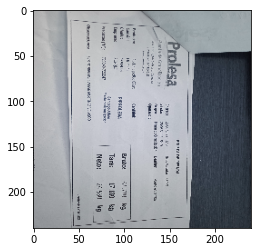

In [ ]:
img = load_img('/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112539.jpg') #,target_size=(200,200)
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
output = saved_model.predict(img)
if output[0] > 0.5:
    print("Remitos_Varios",output)
else:
    print('Remito_OK', output)

Remito_OK [[0.00012906]]


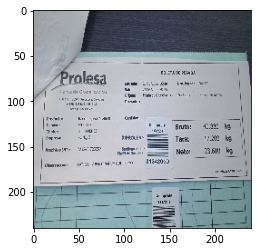

In [ ]:
img = load_img('/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112226.jpg') #,target_size=(200,200)
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
output = saved_model.predict(img)
if output[0] > 0.5:
    print("Remitos_Varios",output)
else:
    print('Remito_OK', output)

Remito_OK [[0.4711638]]


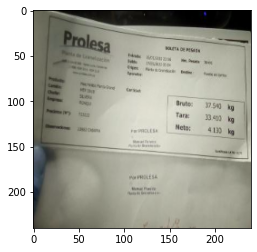

In [ ]:
img = load_img('/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/11840.jpg') #,target_size=(200,200)
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
output = saved_model.predict(img)
if output[0] > 0.5:
    print("Remitos_Varios",output)
else:
    print('Remito_OK', output)

Remitos_Varios [[0.9983646]]


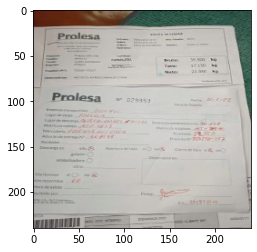

In [ ]:
img = load_img('/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/11839.jpg') #,target_size=(200,200)
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
output = saved_model.predict(img)
if output[0] > 0.5:
    print("Remitos_Varios",output)
else:
    print('Remito_OK', output)

Remitos_Varios [[0.995998]]


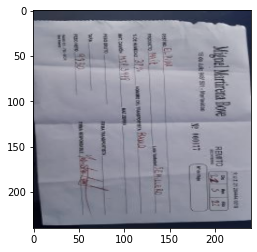

In [ ]:
img = load_img('/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remitos_Varios/12058.jpg') #,target_size=(200,200)
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
output = saved_model.predict(img)
if output[0] > 0.5:
    print("Remitos_Varios",output)
else:
    print('Remito_OK', output)

Creamos una funcion para recorrer las imagenes de TEST y ponerlas en un dataset para luego pasarlas por el modelo y comparar el resultado de la predicción con lo que la imagen es.

In [ ]:
IMG_DIR_TEST_OK= '/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK'
IMG_DIR_TEST_VARIOS = '/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remitos_Varios'

data_test_ok = []
for filename in os.listdir(IMG_DIR_TEST_OK):
  data_test_ok.append({"image_name": 'Remito_OK/' + filename, "isValid": 0, 'isValidModel': None})

data_test_varios = []
for filename in os.listdir(IMG_DIR_TEST_VARIOS):
  data_test_varios.append({"image_name": 'Remitos_Varios/' + filename, 'isValid': 1,'isValidModel': None})

df_ok = pd.DataFrame(data_test_ok)
df_varios = pd.DataFrame(data_test_varios)
df_result = pd.concat([df_ok, df_varios])
df_result

isValidModel = []
probability = []
for index, row in df_result.iterrows():
  try:
    image = '/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/'+ row["image_name"]
    print(image)
    img = load_img(image)
    img = np.asarray(img)
    img = np.expand_dims(img, axis=0)
    output = saved_model.predict(img)
    if output[0] > 0.5:
      isValidModel.append(1)
      probability.append(float(output[0][0]))
    else:
      isValidModel.append(0)
      probability.append(float(output[0][0]))
  except:
    print('No se procesa img')

df_result['isValidModel'] = isValidModel
df_result['modelProbability'] = probability

/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112226.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112236.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112247.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112256.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112304.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112514.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112523.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112537.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112539.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/ima

Evaluamos la predicción

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df_result['isValid'], df_result['isValidModel']))

              precision    recall  f1-score   support

           0       1.00      0.62      0.76        13
           1       0.72      1.00      0.84        13

    accuracy                           0.81        26
   macro avg       0.86      0.81      0.80        26
weighted avg       0.86      0.81      0.80        26



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df_result['isValid'], df_result['isValidModel'])

array([[ 8,  5],
       [ 0, 13]])

In [ ]:
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(df_result['isValid'], df_result['isValidModel'])


Evaluamos con una matriz de confucion y pese a tener un accuracy de 81% no es buena la predicción por el overfitting 

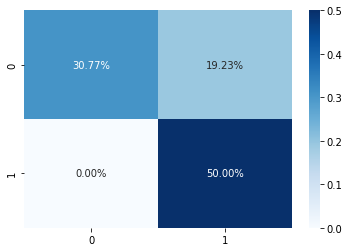

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
fmt='.2%', cmap='Blues')
plt.show()

#Fase 4 - Clasificación, Data Augmentation y Tranfer Learning

Dado que no se obtuvo un buen resultado con el modelo inicial, optamos por investigar y revisar otros tipos de modelos, cambiando por un modelo de aprendizaje por transferencia y como aumentar las imagenes.

En esta fase usaremos Data Augmentation y Tranfer Learning, con el fin de agrandar la muestra y entrenaremos el modelo aprovechando el conocimiento del otro modelo y evaluaremos los resultados obtenidos



https://colab.research.google.com/drive/1FO5CmY_DeCGsvXJ3P0qQH_xKfwCaK1lp?usp=sharing


#Fase 5 - API y OCR  
Para los caso que el modelo determine que es un Remito_OK, se procesará con funciones para extraerle la información mediante uso de OCR y devolver la misma mediante una API, si cumplen serán evaludadas por el modelo y sino rechazarlas.
La API que recibe una imagen y devuelva los datos de OCR obtenidos el dato de Toneladas NETO.

https://colab.research.google.com/drive/1aPu4BkLqa869AMFoOVlud0tCYxuaF1fi?usp=sharing

# Demo

http://ec2-3-92-234-136.compute-1.amazonaws.com:8080/

##Conclusiones


Las imagenes aportadas para el dataset, son información real de una empresa y varios cliente, obtenidas con celulares que no tiene camaras de buena calidad, dado que son celulares usados princial para llamadas o mensajes por whatsapp. Por tanto el dataset contenia más de 1000 imagenes de multiples tamaños, calidad y nitidez.

Si bien previamente pensamos que un dataset de imagenes no era necesario analizar por medio de EDA, luego de hacerlo vemos que nos ayudo mucho, para determinar que imagenes estandares minimos para el uso de OCR.

Verificamos que las imagenes sin procesar o normalizadas no influyen en el entrenamiento, ni dado que no mejoran la eficiencia del modelo.

Por otro lado notamos que la calidad de las imagenes es determinante al momento de usar OCR y por lo cual sino cumple con los minimos requerido no deben ser procesadas por el modelo.


Un factor que si vimos determinante es cantidad de imagenes al entrenar el modelo FASE 3 y por es hicimos una FASE 4 usando aumento de datos y luego con esa data aumentada x 9, agregamos transferencia de aprendizaje.

El uso de data augmentation y transfer learning mejoro mucho el nivel de predicción, llegando a valores de accuracy mayores a 90% y una matriz de confucion con un solo falso positivo.

Es de destacar que en la fase 4, ajustamos el modelo, mediante pruebas de  aumento de cantidad de epoch, parametros de peso de las clases y pudimos mejorar los resultados. 

Predecir imagenes tiene mucho de arte y de prueba ensayo y error, pero fue determinante el aumento de la muestra en cantidad y sin dudas el uso de otro modelo previamente entrenado.


